In [1]:
import numpy as np
import torch
import PIL
import torchvision
from PIL import Image
from diffusers.models import AutoencoderKL

In [2]:
dataset_path = './dataset/'
training_path = dataset_path + 'subj0{}/training_split/'
training_fmri_path = training_path + 'training_fmri/'
training_images_path = training_path + 'training_images/'
testing_path = dataset_path + 'subj0{}/test_split/test_fmri/'

In [3]:
def load_image(path):
    image = Image.open(path).convert("RGB")
    image = np.array(image).astype(np.float32) / 255.0   #(425, 425, 3)
    image = image[None].transpose(0, 3, 1, 2)           # (1, 3, 425, 425)
    image = torch.from_numpy(image)
    return image

In [4]:
def save_image(samples, path):     
    samples = 255 * samples.clamp(0,1)    # (1, 3, 425, 425)
    samples = samples.detach().numpy()
    samples = samples.transpose(0, 2, 3, 1)       #(1, 425, 425, 3)
    image = samples[0]                            #(425, 425, 3)
    image = Image.fromarray(image.astype(np.uint8))
    image.save(path)

In [5]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

In [6]:
def encode_img(input_img):
    # Single image -> single latent in a batch (so size 1, 4, 53, 53)
    if len(input_img.shape)<4:
        input_img = input_img.unsqueeze(0)
    with torch.no_grad():
        latent = vae.encode(input_img*2 - 1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

In [7]:
def decode_img(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach()
    return image


In [8]:
to_pil = torchvision.transforms.ToPILImage() # For transform tensor to PIL image

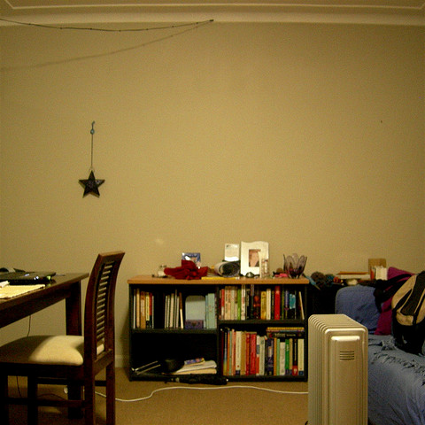

In [9]:
original_image = load_image(training_images_path.format(1) + '0.png')
to_pil(original_image[0])

In [10]:
encoded = encode_img(original_image)
decoded = decode_img(encoded)

In [11]:
print(encoded.shape, decoded.shape)

torch.Size([1, 4, 53, 53]) torch.Size([1, 3, 424, 424])


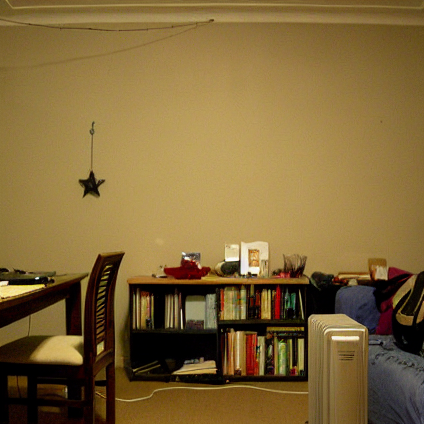

In [12]:
to_pil(decoded[0])